In [1]:
import logging
import os
import random
from collections import Counter
from importlib import reload
import time

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

# import pollock
# from pollock import PollockDataset, PollockModel, load_from_directory

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [3]:
DATA_DIR = '/data/single_cell_classification'
MODEL_DIR = '/models'

In [4]:
snRNA_anndata_fp = '/data/single_cell_classification/tumor/BR/snRNA/merged.h5ad'
snATAC_anndata_fp = '/data/single_cell_classification/tumor/BR/snATAC/merged.h5ad'

In [5]:
snRNA_adata = sc.read_h5ad(snRNA_anndata_fp)
snRNA_adata = snRNA_adata[snRNA_adata.obs['orig.ident']=='TWCE-HT088B1-Bc3']
snRNA_adata

View of AnnData object with n_obs × n_vars = 970 × 16153
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'ident'
    layers: 'logcounts'

In [6]:
snATAC_adata = sc.read_h5ad(snATAC_anndata_fp)
snATAC_adata.obs['cell_type'] = list(snATAC_adata.obs['predicted.id'])
snATAC_adata

AnnData object with n_obs × n_vars = 8474 × 19779
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'nucleosome_group', 'TSS.enrichment', 'high.tss', 'peaks_snn_res.0.8', 'seurat_clusters', 'nCount_ACTIVITY', 'nFeature_ACTIVITY', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Endothelial', 'prediction.score.CD8_T', 'prediction.score.CD4_T', 'prediction.score.Fibroblast', 'prediction.score.Plasma', 'prediction.score.Macrophage', 'prediction.score.NK', 'prediction.score.Mast', 'prediction.score.max', 'ident', 'cell_type'
    layers: 'logcounts'

In [7]:
snRNA_adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,cell_type,ident
index,,,,,,,,,,
TWCE-HT088B1-Bc3_AAACCCAAGAGATCGC-1,TWCE-HT088B1-Bc3,5761.0,1947,0.045652,3527.0,1798,1,1,Tumor,Tumor
TWCE-HT088B1-Bc3_AAACCCAAGGTTCTTG-1,TWCE-HT088B1-Bc3,3636.0,1386,0.059956,3146.0,1376,6,6,Tumor,Tumor
TWCE-HT088B1-Bc3_AAACGCTTCCTCAGAA-1,TWCE-HT088B1-Bc3,5009.0,1975,0.083849,3393.0,1918,0,0,Endothelial,Endothelial
TWCE-HT088B1-Bc3_AAAGGATAGTGCTCGC-1,TWCE-HT088B1-Bc3,1232.0,592,0.093344,2502.0,623,10,10,Tumor,Tumor
TWCE-HT088B1-Bc3_AAAGGGCCAACTCCAA-1,TWCE-HT088B1-Bc3,10777.0,3365,0.063376,2953.0,1472,0,0,Endothelial,Endothelial
...,...,...,...,...,...,...,...,...,...,...
TWCE-HT088B1-Bc3_TTTCCTCAGCCGAACA-1,TWCE-HT088B1-Bc3,1345.0,664,0.033457,2547.0,669,3,3,CD4_T,CD4_T
TWCE-HT088B1-Bc3_TTTCCTCGTGGATCGA-1,TWCE-HT088B1-Bc3,4071.0,1477,0.077868,3254.0,1469,11,11,Macrophage,Macrophage
TWCE-HT088B1-Bc3_TTTGACTTCGGCTTGG-1,TWCE-HT088B1-Bc3,2596.0,1021,0.082049,2708.0,1017,1,1,Tumor,Tumor


In [8]:
snATAC_adata.obs

,orig.ident,nCount_peaks,nFeature_peaks,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,prediction.score.CD8_T,prediction.score.CD4_T,prediction.score.Fibroblast,prediction.score.Plasma,prediction.score.Macrophage,prediction.score.NK,prediction.score.Mast,prediction.score.max,ident,cell_type
index,,,,,,,,,,,,,,,,,,,,,
TWCE-HT088B1-Bc3_TWCE-HT088B1-S1H1A2K2Y2N1_CGCAATAGTTCCATCC-1,ATAC,6796.0,3018,10044,1954,121,67,1152,38,6712,...,0.005379,0.036888,0.000000,0.000000,0.012197,0.006326,0.000000,0.939209,2,Tumor
TWCE-HT088B1-Bc3_TWCE-HT088B1-S1H1A2K2Y2N1_GTAGTACGTTGCTTGA-1,ATAC,5696.0,2633,9704,1554,99,80,682,134,7155,...,0.000000,0.004065,0.930636,0.000000,0.000000,0.000000,0.000000,0.930636,1,Fibroblast
TWCE-HT088B1-Bc3_TWCE-HT088B1-S1H1A2K2Y2N1_GTTATTCTCTACATCT-1,ATAC,7776.0,3136,13915,2777,203,113,1044,23,9755,...,0.018184,0.273866,0.000000,0.001137,0.009159,0.011332,0.686323,0.686323,6,Mast
TWCE-HT088B1-Bc3_TWCE-HT088B1-S1H1A2K2Y2N1_CGCGCAATCTGGAAGG-1,ATAC,21026.0,8511,28326,4851,348,242,1910,55,20920,...,0.000000,0.000000,0.056559,0.011413,0.027084,0.000000,0.000000,0.904944,0,Tumor
TWCE-HT088B1-Bc3_TWCE-HT088B1-S1H1A2K2Y2N1_GGGAACAAGCTTCAAC-1,ATAC,10525.0,4547,27690,5266,362,163,3470,454,17975,...,0.000000,0.079488,0.183399,0.014177,0.000000,0.000000,0.000000,0.722936,2,Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TWCE-HT088B1-Bc3_TWCE-HT088B1-S1H2A2Y1N1_CATGCCTCAAGGCGTA-1,ATAC,2816.0,1316,11217,1965,138,101,1086,12,7915,...,0.400309,0.304507,0.000000,0.032088,0.006249,0.256847,0.000000,0.400309,5,CD8_T
TWCE-HT088B1-Bc3_TWCE-HT088B1-S1H2A2Y1N1_TCACCTGAGTGCAACG-1,ATAC,8268.0,3843,15832,3600,132,187,1159,94,10660,...,0.000000,0.000000,0.999737,0.000000,0.000000,0.000000,0.000000,0.999737,2,Fibroblast
TWCE-HT088B1-Bc3_TWCE-HT088B1-S1H2A2Y1N1_TGAGCCGAGTTGAATG-1,ATAC,7035.0,3379,12720,1957,98,166,1279,1107,8113,...,0.000000,0.002708,0.064056,0.018743,0.000000,0.000000,0.000000,0.808545,1,Tumor


In [9]:
# sc.pp.normalize_total(snRNA_adata, target_sum=1e6)
sc.pp.log1p(snRNA_adata)
snRNA_adata.raw = snRNA_adata

/miniconda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [10]:
# sc.pp.normalize_total(snATAC_adata, target_sum=1e6)
sc.pp.log1p(snATAC_adata)
snATAC_adata.raw = snATAC_adata

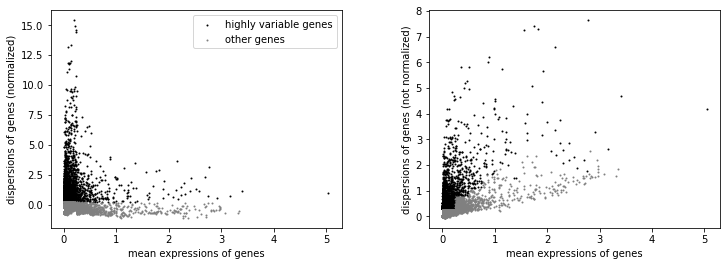

In [11]:
sc.pp.highly_variable_genes(snRNA_adata, min_mean=0.0, max_mean=10., min_disp=0.2)
sc.pl.highly_variable_genes(snRNA_adata)

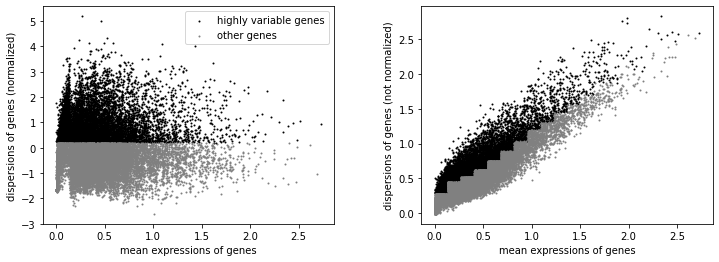

In [12]:
sc.pp.highly_variable_genes(snATAC_adata, min_mean=0.0, max_mean=10., min_disp=0.2)
sc.pl.highly_variable_genes(snATAC_adata)

In [13]:
a = set(snRNA_adata.var.index)
b = set(snATAC_adata.var.index)
s = a.intersection(b)
len(s)

13936

In [14]:
snRNA_adata = snRNA_adata[:, sorted(s)]
snATAC_adata = snATAC_adata[:, sorted(s)]

In [15]:
Counter(snRNA_adata.obs['cell_type']).most_common()

[('Tumor', 302),
 ('Endothelial', 225),
 ('Fibroblast', 195),
 ('Macrophage', 110),
 ('CD4_T', 66),
 ('Plasma', 22),
 ('CD8_T', 21),
 ('Mast', 16),
 ('NK', 13)]

In [16]:
Counter(snATAC_adata.obs['cell_type']).most_common()

[('Tumor', 5694),
 ('Fibroblast', 1696),
 ('Endothelial', 361),
 ('Macrophage', 351),
 ('CD4_T', 176),
 ('CD8_T', 74),
 ('Mast', 71),
 ('Plasma', 47),
 ('NK', 4)]

In [17]:
snRNA_adata.obs['dataset'] = 'snRNA'
snATAC_adata.obs['dataset'] = 'snATAC'

combined_adata = snRNA_adata.concatenate(snATAC_adata)
combined_adata

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 9444 × 13936
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'ident', 'dataset', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'nucleosome_group', 'TSS.enrichment', 'high.tss', 'peaks_snn_res.0.8', 'nCount_ACTIVITY', 'nFeature_ACTIVITY', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Endothelial', 'prediction.score.CD8_T', 'prediction.score.CD4_T', 'prediction.score.Fibroblast', 'prediction.score.Plasma', 'prediction.score.Macrophage

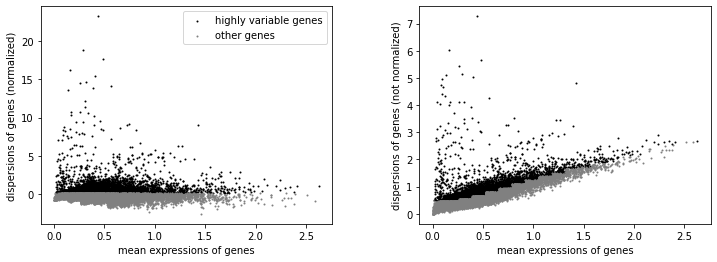

In [18]:
sc.pp.highly_variable_genes(combined_adata, min_mean=0.0, max_mean=10., min_disp=0.1)
sc.pl.highly_variable_genes(combined_adata)

In [19]:
# np.count_nonzero(combined_adata.var.highly_variable)

In [20]:
sc.pp.scale(combined_adata, max_value=None)
combined_adata

AnnData object with n_obs × n_vars = 9444 × 13936
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'ident', 'dataset', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'nucleosome_group', 'TSS.enrichment', 'high.tss', 'peaks_snn_res.0.8', 'nCount_ACTIVITY', 'nFeature_ACTIVITY', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Endothelial', 'prediction.score.CD8_T', 'prediction.score.CD4_T', 'prediction.score.Fibroblast', 'prediction.score.Plasma', 'prediction.score.Macrophage

In [21]:
sc.tl.pca(combined_adata, svd_solver='arpack')
sc.pp.neighbors(combined_adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(combined_adata)

/miniconda/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets
/miniconda/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/miniconda/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/miniconda/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connect

... storing 'orig.ident' as categorical
... storing 'SCT_snn_res.0.5' as categorical
... storing 'seurat_clusters' as categorical
... storing 'cell_type' as categorical
... storing 'ident' as categorical
... storing 'dataset' as categorical
... storing 'cell_id' as categorical
... storing 'nucleosome_group' as categorical
... storing 'high.tss' as categorical
... storing 'peaks_snn_res.0.8' as categorical
... storing 'predicted.id' as categorical


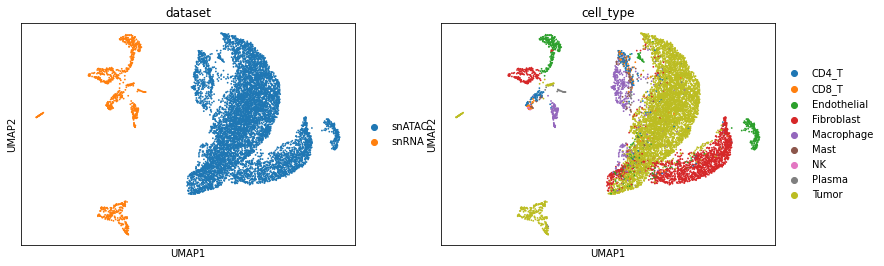

In [22]:
sc.pl.umap(combined_adata, color=['dataset', 'cell_type'])

In [23]:
def cap_list(ls, n=100, hard_cap=False):
    if len(ls) > n:
        return random.sample(ls, n)
    if hard_cap:
        return ls
    return random.sample(ls, int(len(ls) * .8))


def get_balanced_ids(adata, key, n_per_cell_type, hard_cap=False):
    cell_type_to_idxs = {}
    for cell_id, cell_type in zip(adata.obs.index, adata.obs[key]):
        if cell_type not in cell_type_to_idxs:
            cell_type_to_idxs[cell_type] = [cell_id]
        else:
            cell_type_to_idxs[cell_type].append(cell_id)

    cell_type_to_idxs = {k:cap_list(ls, n_per_cell_type, hard_cap=hard_cap)
                        for k, ls in cell_type_to_idxs.items()}

    train_ids = np.asarray([x for ls in cell_type_to_idxs.values() for x in ls])
    val_ids = np.asarray(list(set(adata.obs.index) - set(train_ids)))
    
    return train_ids, val_ids

def grab_n(adata, key, n_per_cell_type):
    train_ids, _ = get_balanced_ids(adata, key, n_per_cell_type, hard_cap=True)
    return adata[train_ids].X


In [24]:

snRNA_train_ids, snRNA_val_ids = get_balanced_ids(combined_adata[combined_adata.obs['dataset']=='snRNA'],
                                               'cell_type', 200)

snATAC_train_ids, snATAC_val_ids = get_balanced_ids(combined_adata[combined_adata.obs['dataset']=='snATAC'],
                                               'cell_type', 200)

train_ids = np.concatenate((snRNA_train_ids, snATAC_train_ids))
val_ids = np.concatenate((snRNA_val_ids, snATAC_val_ids))

train_adata = combined_adata[train_ids].copy()
val_adata = combined_adata[val_ids].copy()

In [25]:
from sklearn.preprocessing import MaxAbsScaler
X_train = train_adata.X
X_val = val_adata.X

scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train.shape, X_val.shape

((1846, 13936), (7598, 13936))

In [26]:
TRAIN_BUF = 10000
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(X_val).batch(BATCH_SIZE)

In [27]:
class BVAE(tf.keras.Model):
  def __init__(self, latent_dim, input_size):
    super(BVAE, self).__init__()
    self.latent_dim = latent_dim
    self.input_size = input_size
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(input_size,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(input_size),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [28]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x, alpha=0.00005):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  kl_loss = .5 * tf.reduce_sum(tf.exp(logvar) + tf.square(mean) - 1. - logvar, axis=1)
  reconstruction_loss = .5 * tf.reduce_sum(tf.square((x - x_logit)), axis=1)

  overall_loss = tf.reduce_mean(reconstruction_loss + (alpha * kl_loss))
  return overall_loss

@tf.function
def compute_apply_gradients(model, x, optimizer, alpha=.00005):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, alpha=alpha)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [29]:
# epochs = 250
# latent_dim = 100
# # alpha = 0.1
# alpha = 2.

epochs = 100
latent_dim = 50
# alpha = 0.1
alpha = 2.

model = BVAE(latent_dim, X_train.shape[1])

In [30]:
# vals = grab_n(val_adata, 'cell_type', 10)
# vals = tf.data.Dataset.from_tensor_slices(vals).batch(BATCH_SIZE)

In [31]:
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer, alpha=alpha)
  end_time = time.time()

  if epoch % 1 == 0:
    train_loss = tf.keras.metrics.Mean()
    for train_x in train_dataset:
      train_loss(compute_loss(model, train_x, alpha=alpha))
        
    val_loss = tf.keras.metrics.Mean()
    for test_x in test_dataset.take(10):
      val_loss(compute_loss(model, test_x, alpha=alpha))

    print(f'epoch: {epoch}, train loss: {train_loss.result()}, val loss: {val_loss.result()}')

epoch: 1, train loss: 290.8367919921875, val loss: 355.15032958984375
epoch: 2, train loss: 273.8674011230469, val loss: 331.48895263671875
epoch: 3, train loss: 268.3399353027344, val loss: 323.24066162109375
epoch: 4, train loss: 254.08688354492188, val loss: 303.8584289550781
epoch: 5, train loss: 249.03341674804688, val loss: 296.6759338378906
epoch: 6, train loss: 247.04562377929688, val loss: 292.81768798828125
epoch: 7, train loss: 244.8422393798828, val loss: 291.81292724609375
epoch: 8, train loss: 244.06680297851562, val loss: 291.1236267089844
epoch: 9, train loss: 242.21620178222656, val loss: 291.43280029296875
epoch: 10, train loss: 241.0408477783203, val loss: 289.89007568359375
epoch: 11, train loss: 240.27249145507812, val loss: 288.5039978027344
epoch: 12, train loss: 239.3850860595703, val loss: 288.6777648925781
epoch: 13, train loss: 238.51168823242188, val loss: 286.78131103515625
epoch: 14, train loss: 238.00680541992188, val loss: 286.1744689941406
epoch: 15, tr

In [32]:
cell_embeddings = None
for i in range(0, combined_adata.X.shape[0], 1000):
    

    mean, logvar = model.encode(combined_adata.X[i:i+1000])
    
    if cell_embeddings is None:
        cell_embeddings = model.reparameterize(mean, logvar).numpy()
    else:
        cell_embeddings = np.concatenate((cell_embeddings, model.reparameterize(mean, logvar).numpy()), axis=0)
cell_embeddings.shape

(9444, 50)

In [33]:
import umap
combined_adata.obsm['cell_embeddings'] = cell_embeddings
combined_adata.obsm['cell_embedding_umap'] = umap.UMAP().fit_transform(combined_adata.obsm['cell_embeddings'])
combined_adata.obs['cell_embedding_umap1'] = combined_adata.obsm['cell_embedding_umap'][:, 0]
combined_adata.obs['cell_embedding_umap2'] = combined_adata.obsm['cell_embedding_umap'][:, 1]

combined_adata

AnnData object with n_obs × n_vars = 9444 × 13936
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'ident', 'dataset', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'nucleosome_group', 'TSS.enrichment', 'high.tss', 'peaks_snn_res.0.8', 'nCount_ACTIVITY', 'nFeature_ACTIVITY', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Endothelial', 'prediction.score.CD8_T', 'prediction.score.CD4_T', 'prediction.score.Fibroblast', 'prediction.score.Plasma', 'prediction.score.Macrophage

In [34]:
sc.pp.neighbors(combined_adata, n_neighbors=10, use_rep='cell_embeddings')
# sc.tl.pca(combined_adata, n_comps=100, )
sc.tl.umap(combined_adata, )

/miniconda/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/miniconda/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/miniconda/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


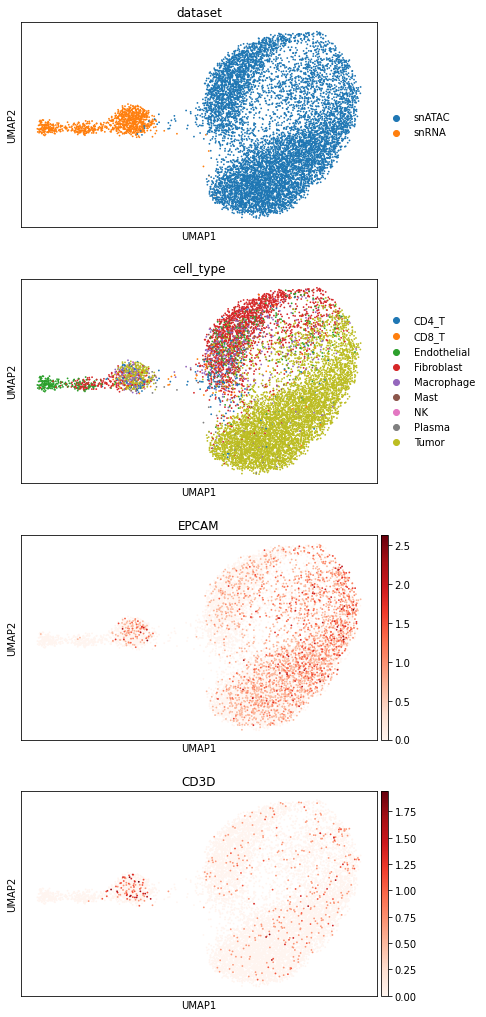

In [35]:
markers = ['EPCAM', 'CD3D']
variables = ['dataset', 'cell_type']
variables += markers
sc.pl.umap(combined_adata, color=variables, color_map='Reds', ncols=1)

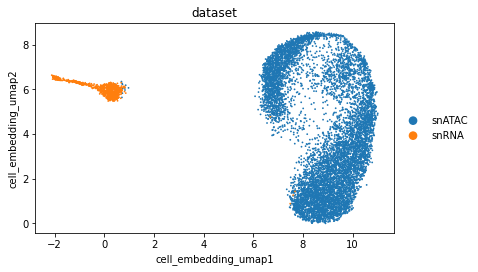

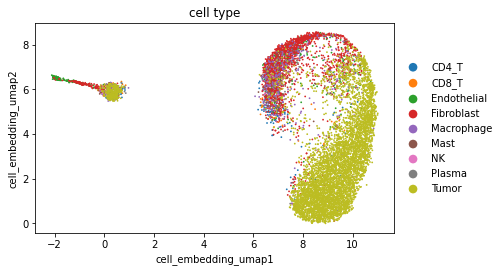

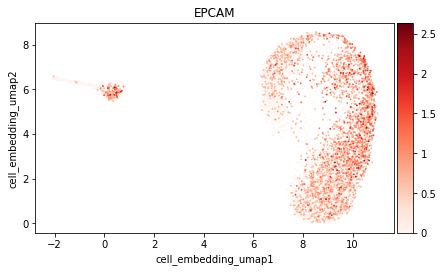

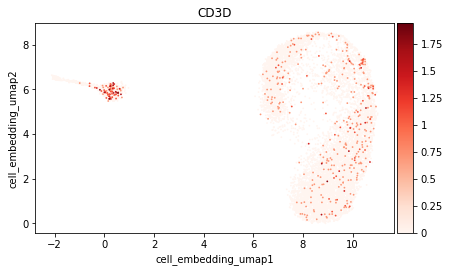

In [36]:
markers = ['EPCAM', 'CD3D']
variables = ['dataset', 'cell_type']
variables += markers
for var in variables:
    if var in combined_adata.var.index or var in combined_adata.obs.columns:
        sc.pl.scatter(combined_adata, x='cell_embedding_umap1', y='cell_embedding_umap2', color=var,
                     frameon=False, color_map='Reds')
        plt.show()


In [37]:
avg_snRNA = np.mean(combined_adata[combined_adata.obs['dataset']=='snRNA'].obsm['cell_embeddings'], axis=0)
avg_snATAC = np.mean(combined_adata[combined_adata.obs['dataset']=='snATAC'].obsm['cell_embeddings'], axis=0)

mean = np.mean(np.asarray([avg_snRNA, avg_snATAC]), axis=0)

snRNA_delta = mean - avg_snRNA
snATAC_delta = mean - avg_snATAC
delta = avg_snRNA - avg_snATAC


In [38]:
def operation(latent, dataset):
    if dataset == 'snRNA': return latent + snRNA_delta
    if dataset == 'snATAC': return latent + snATAC_delta
    
#     return latent

transformed_embeddings = np.asarray([operation(latent, dataset)
                           for latent, dataset in zip(combined_adata.obsm['cell_embeddings'],
                                                      combined_adata.obs['dataset'])])

combined_adata.obsm['transformed_embeddings'] = transformed_embeddings
combined_adata.obsm['transformed_embeddings_umap'] = umap.UMAP(
    ).fit_transform(combined_adata.obsm['transformed_embeddings'])
combined_adata.obs['transformed_embeddings_umap1'] = combined_adata.obsm['transformed_embeddings_umap'][:, 0]
combined_adata.obs['transformed_embeddings_umap2'] = combined_adata.obsm['transformed_embeddings_umap'][:, 1]

combined_adata

AnnData object with n_obs × n_vars = 9444 × 13936
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'ident', 'dataset', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'nucleosome_group', 'TSS.enrichment', 'high.tss', 'peaks_snn_res.0.8', 'nCount_ACTIVITY', 'nFeature_ACTIVITY', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Endothelial', 'prediction.score.CD8_T', 'prediction.score.CD4_T', 'prediction.score.Fibroblast', 'prediction.score.Plasma', 'prediction.score.Macrophage

In [39]:
sc.pp.neighbors(combined_adata, n_neighbors=10, use_rep='transformed_embeddings')
# sc.tl.pca(combined_adata, n_comps=100, )
sc.tl.umap(combined_adata, )

/miniconda/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/miniconda/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/miniconda/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


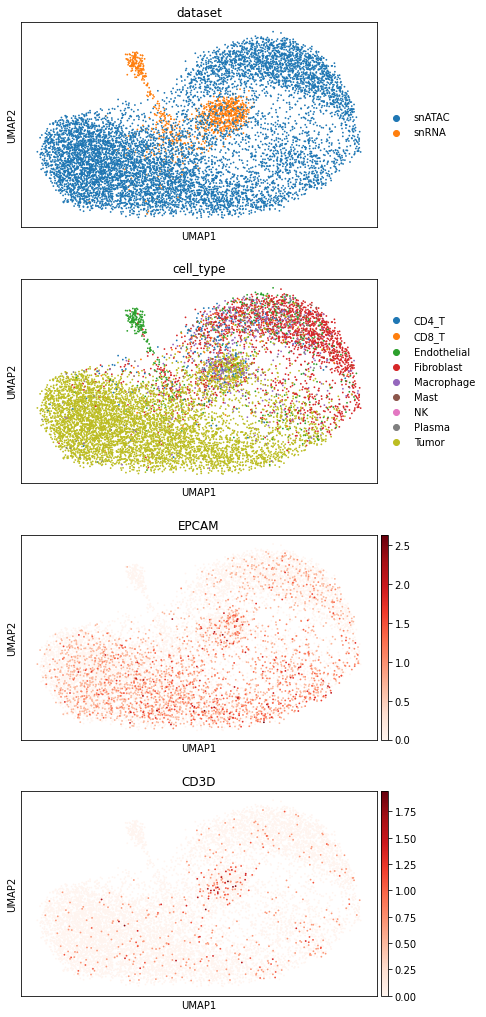

In [40]:
markers = ['EPCAM', 'CD3D']
variables = ['dataset', 'cell_type']
variables += markers
sc.pl.umap(combined_adata, color=variables, color_map='Reds', ncols=1)

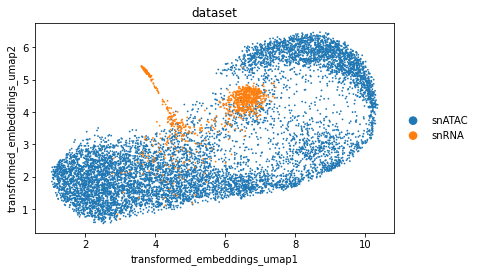

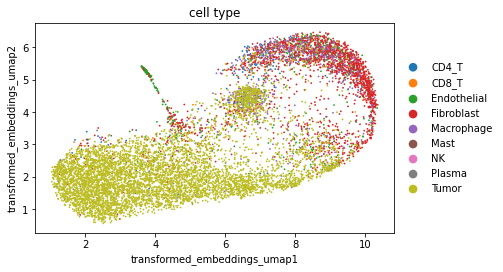

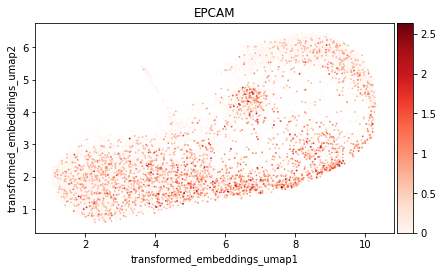

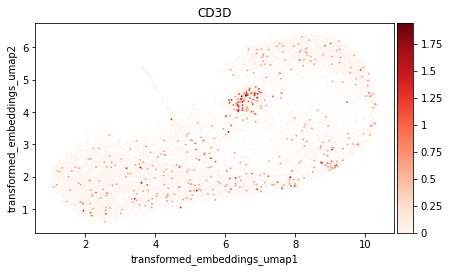

In [41]:
variables = ['dataset', 'cell_type']
variables += markers
for var in variables:
    if var in combined_adata.var.index or var in combined_adata.obs.columns:
        sc.pl.scatter(combined_adata, x='transformed_embeddings_umap1',
                      y='transformed_embeddings_umap2', color=var,
                      frameon=False, color_map='Reds')
        plt.show()